<a href="https://colab.research.google.com/github/ishaan-arya/automated-essay-grading/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.utils import shuffle
import nltk
import re

from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import twitter_samples 

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [4]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [5]:
df_clean = df.drop(['textID', 'selected_text'], axis = 1)
df_clean.text=df_clean.text.astype(str)
df_clean

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [6]:
def clean_tweet(token):
    token = token.lower()
    token = re.sub(r'@[a-z0-9_]\S+','', token)
    token = re.sub(r'#[a-z0-9_]\S+','', token)
    token = re.sub(r'&[a-z0-9_]\S+','', token)
    token = re.sub(r'[?!.+,;$£%&"*`]+','', token)
    token = re.sub(r'rt[\s]+','', token)
    token = re.sub(r'\d+','', token)
    token = re.sub(r'\$', '', token)
    token = re.sub(r'rt+','', token)
    token = re.sub(r'https?:?\/\/\S+','', token)
    return token

In [7]:
df_clean['text'] = df_clean['text'].apply(lambda x:clean_tweet(x))
df_clean

,text,sentiment
0,id have responded if i were going,neutral
1,sooo sad i will miss you here in san diego,negative
2,my boss is bullying me,negative
3,what interview leave me alone,negative
4,sons of why couldnt they put them on the rel...,negative
...,...,...
27476,wish we could come see u on denver husband l...,negative
27477,ive wondered about rake to the client has ma...,negative
27478,yay good for both of you enjoy the break - yo...,positive
27479,but it was woh it,positive


In [29]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
stop_words = set(stopwords.words('english')) 

def remove_stop_words(tweet):
    word_tokens = word_tokenize(tweet) 
    filtered_tweet = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

df_clean['text'] = df_clean['text'].apply(lambda x:remove_stop_words(x))  

In [31]:
df_clean

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,boss bullying,negative
3,interview leave alone,negative
4,sons couldnt put releases already bought,negative
...,...,...
27476,wish could come see u denver husband lost job ...,negative
27477,ive wondered rake client made clear net dont f...,negative
27478,yay good enjoy break - probably need hectic we...,positive
27479,woh,positive


In [32]:
df_clean['sentiment'] = df_clean['sentiment'].replace(['neutral'],'0')
df_clean['sentiment'] = df_clean['sentiment'].replace(['positive'],'1')
df_clean['sentiment'] = df_clean['sentiment'].replace(['negative'],'-1')
df_clean

,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,boss bullying,-1
3,interview leave alone,-1
4,sons couldnt put releases already bought,-1
...,...,...
27476,wish could come see u denver husband lost job ...,-1
27477,ive wondered rake client made clear net dont f...,-1
27478,yay good enjoy break - probably need hectic we...,1
27479,woh,1


In [33]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(max_features = 5000, ngram_range=(1, 3), stop_words='english')
count_vectors = vectorizer.fit_transform(df_clean['text'])
X = count_vectors.toarray()
y = df_clean['sentiment'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [13]:
X_train.shape

(21984, 5000)

In [14]:
X_test.shape

(5497, 5000)

In [66]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(X_test), y_test)
print('accuracy_score_mnb = '+str('{:04.2f}'.format(accuracy_score_mnb*100))+'%')

accuracy_score_mnb = 64.71%


In [67]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train, y_train)
accuracy_score_gnb = metrics.accuracy_score(GNB.predict(X_test), y_test)
print('accuracy_score_gnb = '+str('{:04.2f}'.format(accuracy_score_gnb*100))+'%')

accuracy_score_gnb = 41.99%


In [68]:
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(X_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(X_test), y_test)
print('accuracy_score_bnb = '+str('{:04.2f}'.format(accuracy_score_bnb*100))+'%')

accuracy_score_bnb = 64.58%


In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 100)
classifier = rf_classifier.fit(X_train, y_train)
accuracy_score_rf = metrics.accuracy_score(classifier.predict(X_test), y_test)
print('accuracy_score_rf = '+str('{:04.2f}'.format(accuracy_score_rf*100))+'%')

accuracy_score_rf = 68.35%


In [72]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='newton-cg')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score_logistic = metrics.accuracy_score(y_pred, y_test)
print('accuracy_score_logistic = '+str('{:04.2f}'.format(accuracy_score_logistic*100))+'%')

accuracy_score_logistic = 67.55%


1 0.6070583954884482
11 0.6732763325450246
21 0.672184828088048
31 0.6812806985628524
41 0.6825541204293251
51 0.6780061851919229
61 0.6765508459159542
71 0.676187011096962
81 0.680371111515372
91 0.6787338548299072
101 0.6783700200109151
111 0.6796434418773877
121 0.680371111515372
131 0.6794615244678915
141 0.6790976896488994
151 0.6770965981444425
161 0.6792796070583955
171 0.682372203019829
181 0.6798253592868837
191 0.6820083682008368
201 0.6821902856103329
211 0.680189194105876
221 0.680189194105876
231 0.6798253592868837
241 0.6827360378388212


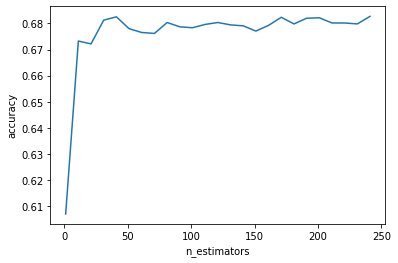

In [15]:
#finding optimal n-estimators 
import matplotlib.pyplot as plt

accuracy = []
arr = []
i=1
count = 0
while i<250:
  rf_classifier = RandomForestClassifier(n_estimators = i)
  classifier = rf_classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy_score_rf = metrics.accuracy_score(classifier.predict(X_test), y_test)
  print(i, accuracy_score_rf)
  accuracy.append(metrics.accuracy_score(y_pred, y_test))
  arr.append(i)
  count = count+1
  i=i+10
plt.plot(arr,accuracy) 
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.show()

In [21]:
import tweepy
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [20]:
api_key = 'siXBKHwhmlGqiZWAhrHmjage5'
api_secret = 'SmPpDBxptBjGZBr1ZBtb6RyI2SIJQHYVeouScVlDY2GeBlGzI1'
access_token = '871008174337277953-us0kvxiCwCeh9pEs4THeahrdAtyjHZV'
access_token_secret = 'JfkFp5LL8kFDN8fBD9Rt3aDV2VhFh6vY2LJ8jYZBfiyXl'

In [22]:
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [23]:
keyword = 'bitcoin'
limit = 200

In [24]:
def text_clean(tweet):
    # Making all the text lowercase
    tweet = tweet.lower()
    #Replacing mentions (@...) with an empty string
    tweet = re.sub(r'@[a-z0-9]\S+','', tweet)
    #Replacing hastags (#...) with an empty string
    tweet = re.sub(r'#[a-z0-9]\S+','', tweet)
    #Replacing ampersand (&...) with an empty string
    tweet = re.sub(r'&[a-z0-9]\S+','', tweet)
    #Replacing symbols with an empty string
    tweet = re.sub(r'[?!.,;:$%&+"]+','', tweet)
    #Replacing RT with an empty string
    tweet = re.sub(r'rt[\s]+','', tweet)
    #Replacing URLS (http../https...) with an empty string
    tweet = re.sub(r'https?:?\/\/\S+','', tweet)
    #Replacing numbers with an empty string
    tweet = re.sub(r'\d+','', tweet)
    return tweet

In [25]:
def tweet_search(keyword):
    i = 0
    tweets_df = pd.DataFrame(columns = ['Datetime', 'Tweet', 'Username','Retweets', 'Followers'])
    for tweet in tweepy.Cursor(api.search, q = keyword, count = 100, lang = 'en', tweet_mode = 'extended').items():
        print('Tweets downloaded:', i, '/', limit, end = '\r')
        if tweet.user.followers_count > 1000:
            tweets_df = tweets_df.append({'Datetime': tweet.created_at, 
                                          'Tweet': tweet.full_text, 
                                          'Username': tweet.user.screen_name, 
                                          'Retweets': tweet.retweet_count, 
                                          'Followers': tweet.user.followers_count,}, ignore_index = True)
            i += 1
        if i >= limit:
            break
        else:
            pass
    tweets_df['Datetime'] = pd.to_datetime(tweets_df['Datetime'], format = '%Y.%m.%d %H:%M:%S')
    tweets_df.set_index('Datetime', inplace = True)
    # tweets_df.to_csv(keyword + '.csv', encoding = 'utf-8')
    tweets_df['CleanTweet'] = tweets_df['Tweet'].apply(text_clean)
    # Removing duplicate tweets / retweets
    tweets_df.drop_duplicates(subset=['Tweet'], inplace = True)
    return tweets_df

In [26]:
tweets_df = tweet_search(keyword)

In [27]:
tweets_df

,Tweet,Username,Retweets,Followers,CleanTweet
Datetime,,,,,
2021-09-22 17:12:42,RT @rogeradcock7: This is just for fun\nOf cou...,weepaddyirish,8,2008,this is just for fun\nof course will come out...
2021-09-22 17:12:41,Dfinity to Launch Bitcoin Smart Contracts on t...,techsocialnet,0,7418,dfinity to launch bitcoin smacontracts on the ...
2021-09-22 17:12:38,"""Wealth is as much a way of thinking as it is ...",wealthbelite,0,7926,wealth is as much a way of thinking as it is f...
2021-09-22 17:12:38,#Bitcoin #News #ADAUSD #BitcoinNews #BTCUSD Sm...,dumbwire,0,29086,smacontracts coming to bitcoin the ultima...
2021-09-22 17:12:30,RT @BITVOLT7: We still don’t know the true imp...,ArcadeCityMayor,33,1421,we still don’t know the true implications of b...
...,...,...,...,...,...
2021-09-22 17:06:00,"RT @NakamotoQuotes: For greater privacy, it's ...",SachinMeier,31,1428,for greater privacy it's best to use bitcoin a...
2021-09-22 17:06:00,"Sorry bears, It’s time to forget about 38K. Yo...",minkyutekken,1,1350,sorry bears it’s time to forget about k you’d ...
2021-09-22 17:05:58,RT @Davincij15: Bitcoin fire sale is on right ...,Johnfost222,178,9742,bitcoin fire sale is on right now who is buyin...
